In [1]:
import os
import json
import time

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from codes.utils import *
from codes.loss_network import *
from torch.autograd import Variable
from codes.dataloader import CocoDataset
from codes.style_bank_net import TransformerNet
from codes.image_folder_functions import divide_style_info

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# initial some configurations
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
kwargs = {}
if torch.cuda.is_available():
    print 'cuda is available'
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 2, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')

cuda is available


In [3]:
# creat dataloader
IMAGE_SIZE = 256
BATCH_SIZE = 4

train_transform = transforms.Compose([
    transforms.Scale(IMAGE_SIZE),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    tensor_normalizer()
])

train_dataset = CocoDataset(train_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [4]:
# creat lossnetwork which use VGG16 to compute loss
loss_network = LossNetwork()
if torch.cuda.is_available():
    loss_network = loss_network.cuda()
loss_network.eval()

LossNetwork (
  (vgg_layers): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=

(1707, 775)
(1, 3, 256, 563)


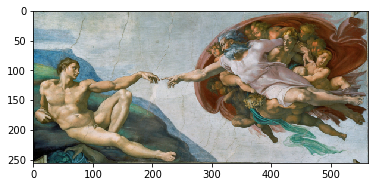

4096


In [5]:
# test our loss_network
style_transform = transforms.Compose([
    transforms.Scale(IMAGE_SIZE),
    transforms.ToTensor(),
    tensor_normalizer()
])

style_image = Image.open('datasets/styles/The_Creation_of_Adam.JPG').convert('RGB')
print style_image.size
style_image = style_transform(style_image).unsqueeze(0)

if torch.cuda.is_available():
    style_image = style_image.cuda()

print style_image.cpu().numpy().shape
plt.figure()
plt.imshow(recover_image(style_image.cpu().numpy())[0])
plt.show()

style_features = loss_network(Variable(style_image))
style_gram = [Variable(gram_matrix(x).data, requires_grad=False) for x in style_features]
print style_gram[0].numel()

In [6]:
style_gram_list, stylize_image = [], []
style_list = ['picasso.jpg', 'spot.jpg', 'The_Great_Wave_off_Kanagawa.jpg', 'watercolour.jpg']
for style_dir in style_list:
    style_image = os.path.join('datasets', 'styles', style_dir)
#     print style_image
    style_image = Image.open(style_image).convert('RGB')
    
#     h, w = style_image.size
#     radio = min(600. / h, 600. / w)
#     new_size = (int(radio * h), int(radio * w))
    
    style_transform = transforms.Compose([
        transforms.Scale(IMAGE_SIZE),
        transforms.ToTensor(),
        tensor_normalizer()
    ])
    
    style_image = style_transform(style_image).unsqueeze(0)
    if torch.cuda.is_available():
        style_image = style_image.cuda()
    style_image = Variable(style_image)
    stylize_image.append(style_image)
        
    style_features = loss_network(style_image)
    style_gram = [Variable(gram_matrix(x).data, requires_grad=False) for x in style_features]
    style_gram_list.append(style_gram)

In [7]:
# record current time
current_time = time.strftime('%Y_%m_%d_%H_%M', time.localtime())
generate_image_dir = os.path.join('generate_image', current_time)

In [8]:
transformer = TransformerNet(len(style_list))
mse_loss = torch.nn.MSELoss()

if torch.cuda.is_available():
    transformer = transformer.cuda()

In [ ]:
# train the net !
CONTENT_WEIGHT = 100
STYLE_WEIGHT = 10000
REG_WEIGHT = 1e-5
LOG_INTERVAL = 200
EPOCH = 300
T = 2
LAMBDA = 1

LR = 1e-2
optimizer = torch.optim.Adam(transformer.parameters(), LR)
scheduler = StepLR(optimizer, step_size=30, gamma=0.2)
transformer.train()

count, t = 0, 0

plt.figure()

for epoch in xrange(EPOCH):
    epoch_content_loss, epoch_style_loss, epoch_reg_loss, epoch_identity_loss = 0., 0., 0., 0.
    
    scheduler.step()
    
    for batch_id, content_image in enumerate(train_loader):
        style_id = np.random.randint(0, len(style_list), BATCH_SIZE)
        
        optimizer.zero_grad()
        
        count += len(style_id)
        content_image = Variable(content_image)
        if torch.cuda.is_available():
            content_image = content_image.cuda()
        
        output_image = transformer(content_image, style_id)
        output_features = loss_network(output_image)
#         print output_features[0].size()
        
        content_loss = CONTENT_WEIGHT * get_content_loss(loss_network, content_image, output_features)
        style_loss = STYLE_WEIGHT * get_style_loss(style_gram_list, output_features, style_id)
        reg_loss = REG_WEIGHT * get_regularization_loss(output_image)
        
        total_loss = content_loss + style_loss + reg_loss
        total_loss.backward()
        optimizer.step()
        
        plt.plot(count, total_loss.data[0], 'b.')
        
        epoch_content_loss += content_loss.data[0]
        epoch_style_loss += style_loss.data[0]
        epoch_reg_loss += reg_loss.data[0]
        
#         auto-encoder branch
        t = t + 1
        if t == T + 1:
            t = 0
            sizes, sums = 0., 0.
            for param in transformer.named_parameters():
                if  'style' in param[0]: continue
                sums += param[1].grad.abs().sum()

                p = 1
                for d in param[1].size(): p *= d
                sizes += p
            norm_style = sums / sizes
            
            optimizer.zero_grad()
            
            output_image = transformer(content_image)
            identity_loss = mse_loss(output_image, content_image)
            identity_loss.backward()
            
            sizes,sums = 0.,0.
            for param in transformer.named_parameters():
                if  'style' in param[0]: continue
                sums += param[1].grad.abs().sum()

                p = 1
                for d in param[1].size(): p *= d
                sizes += p
            norm_encoder = sums/sizes
            
            for param in transformer.named_parameters():
                if  'style' in param[0]: continue
                param[1].grad = LAMBDA * norm_style / norm_encoder * param[1].grad 

            optimizer.step()
            epoch_identity_loss += identity_loss.data[0]
        
        if (batch_id + 1) % LOG_INTERVAL == 0:
            mesg = '{} [{}/{}] content: {:.6f} style: {:.6f} reg: {:.6f} identity: {:.6} total: {:.6f}'.format(
                time.ctime(), count % len(train_dataset), len(train_dataset),
                epoch_content_loss / LOG_INTERVAL,
                epoch_style_loss / LOG_INTERVAL,
                epoch_reg_loss / LOG_INTERVAL,
                epoch_identity_loss / LOG_INTERVAL,
                (epoch_content_loss+epoch_style_loss+epoch_reg_loss) / LOG_INTERVAL
            )
            print mesg
            epoch_content_loss, epoch_style_loss, epoch_reg_loss, epoch_identity_loss = 0., 0., 0., 0.
            
            transformer.eval()
            out = transformer(content_image, style_id)
            save_test_image(generate_image_dir, '{}_{}_{}.png'.format(epoch, count, style_list[style_id[0]]),
                           content_image.data, stylize_image[style_id[0]].data, output_image.data)
            transformer.train()
            
# save the model when train finish
current_time = time.strftime('%Y_%m_%d_%H_%M', time.localtime())
torch.save(transformer, os.path.join('models', current_time+'.pkl'))
plt.savefig(os.path.join('models', current_time+'.jpg'))

/home/jiachen/anaconda2/lib/python2.7/site-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")
